Working with Python 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]


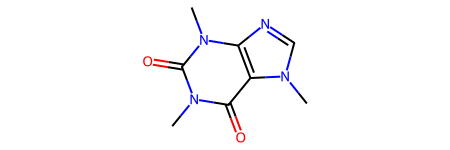

In [1]:
import sys
print(f'Working with Python {sys.version}')

import numpy as np
import pandas as pd
import importlib
#import swifter
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import time
import os
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import rdkit.Chem.Descriptors as Descriptors
from rdkit.Chem import PandasTools
#!pip install spektral


# Deep Learning
import sklearn
#import spektral
from sklearn.model_selection import train_test_split
# Keras
from sklearn.model_selection import train_test_split
#import stellargraph as sg
from rdkit import RDLogger



# Load Modules
from os.path import expanduser
home = expanduser("~")
import fiora.IO.mspReader as mspReader
import fiora.IO.mgfReader as mgfReader
import fiora.visualization.spectrum_visualizer as sv
import fiora.IO.molReader as molReader


RDLogger.DisableLog('rdApp.*')


caffeine_smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
caffeine_mol = Chem.MolFromSmiles(caffeine_smiles)

caffeine_mol

In [2]:
library_directory = f"{home}/data/metabolites/CASMI_2016/CASMI2016_Cat2and3_Challenge_negative_mgf"
!ls $library_directory

Challenge-001.mgf  Challenge-022.mgf  Challenge-043.mgf  Challenge-064.mgf
Challenge-002.mgf  Challenge-023.mgf  Challenge-044.mgf  Challenge-065.mgf
Challenge-003.mgf  Challenge-024.mgf  Challenge-045.mgf  Challenge-066.mgf
Challenge-004.mgf  Challenge-025.mgf  Challenge-046.mgf  Challenge-067.mgf
Challenge-005.mgf  Challenge-026.mgf  Challenge-047.mgf  Challenge-068.mgf
Challenge-006.mgf  Challenge-027.mgf  Challenge-048.mgf  Challenge-069.mgf
Challenge-007.mgf  Challenge-028.mgf  Challenge-049.mgf  Challenge-070.mgf
Challenge-008.mgf  Challenge-029.mgf  Challenge-050.mgf  Challenge-071.mgf
Challenge-009.mgf  Challenge-030.mgf  Challenge-051.mgf  Challenge-072.mgf
Challenge-010.mgf  Challenge-031.mgf  Challenge-052.mgf  Challenge-073.mgf
Challenge-011.mgf  Challenge-032.mgf  Challenge-053.mgf  Challenge-074.mgf
Challenge-012.mgf  Challenge-033.mgf  Challenge-054.mgf  Challenge-075.mgf
Challenge-013.mgf  Challenge-034.mgf  Challenge-055.mgf  Challenge-076.mgf
Challenge-014.mgf  Challe

#### Load spectra
Positives and negative mode spectra

In [3]:
df = []
library_directory = f"{home}/data/metabolites/CASMI_2016/CASMI2016_Cat2and3_Challenge_negative_mgf"

for file in os.listdir(library_directory):
    if file.endswith(".mgf"):
        data = mgfReader.read(os.path.join(library_directory, file), sep="\t")[0]
        data['FILE'] = file
        data['Precursor_type'] = "[M-H]-"
        df += [data]

library_directory = library_directory.replace("negative", "positive")
for file in os.listdir(library_directory):
    if file.endswith(".mgf"):
        data = mgfReader.read(os.path.join(library_directory, file), sep="\t")[0]
        data['FILE'] = file
        data['Precursor_type'] = "[M+H]+"
        df += [data]

df = pd.DataFrame(df)

#### Load solutions

In [4]:
solution = pd.read_csv(os.path.join(library_directory, "solutions_casmi2016_cat2and3.csv"))
# solution = solution[solution["ION_MODE"] == " POSITIVE"]
# solution.reset_index(inplace=True, drop=True)
df = pd.concat([df, solution], axis=1)
print(solution)

    SourceFile  ChallengeName  PRECURSOR_MZ   ION_MODE      RT  nPeaks  \
0     XX834151  Challenge-001      222.0230   NEGATIVE   0.803       5   
1     XX867751  Challenge-002      286.9690   NEGATIVE   1.964       6   
2     XX833051  Challenge-003      223.0071   NEGATIVE   2.371       5   
3     XX845151  Challenge-004      189.9468   NEGATIVE   2.379       2   
4     XX832851  Challenge-005      276.0309   NEGATIVE   3.705       7   
..         ...            ...           ...        ...     ...     ...   
203   XX883201  Challenge-204      369.1250   POSITIVE  14.043      41   
204   XX827002  Challenge-205      331.1904   POSITIVE  14.107      11   
205   XX848701  Challenge-206      489.0435   POSITIVE  14.154       9   
206   XX833703  Challenge-207      303.2319   POSITIVE  14.844      31   
207   XX854101  Challenge-208      496.3997   POSITIVE  15.627      89   

                                   NAME  \
0    5-Aminonaphthalene-2-sulfonic acid   
1        2,7-Naphthalened

In [5]:
# Check that challenges and solutions are aligned correctly
df.apply(lambda x: x["FILE"].split('.')[0] == x["ChallengeName"], axis=1).all()

True

In [6]:

library_candidates_directory = f"{home}/data/metabolites/CASMI_2016/CASMI2016_Cat2and3_Challenge_Candidates"
candidates = []
for file in os.listdir(library_candidates_directory):
    if file.endswith(".csv"):
        data = pd.read_csv(os.path.join(library_candidates_directory, file), sep=",")
        SMILES = list(data["SMILES"])
        d = {'cFILE': file, 'Candidates': SMILES}
        candidates += [d]

candidates = pd.DataFrame(candidates) #.loc[81:].reset_index(drop=True)
print(candidates.head())

               cFILE                                         Candidates
0  Challenge-001.csv  [c1ccc2c(c1)ccc(c2N)S(=O)(=O)O, c1ccc2c(c1)ccc...
1  Challenge-002.csv  [c1cc2c(cccc2S(=O)(=O)O)c(c1)S(=O)(=O)O, c1cc2...
2  Challenge-003.csv  [c1ccc2c(c1)c(ccc2S(=O)(=O)O)O, c1cc(cc2c1ccc(...
3  Challenge-004.csv  [c1cc(c(c(c1)Cl)[N+](=O)[O-])Cl, c1c(cc(cc1Cl)...
4  Challenge-005.csv  [Cn1cnc(c1Sc2c3c(nc[nH]3)ncn2)[N+](=O)[O-], c1...


In [7]:
df = pd.concat([df, candidates], axis=1)
df.apply(lambda x: x["cFILE"].split('.')[0] == x["ChallengeName"], axis=1).all()

True

#### Saving the data
Set to *True* only when a new set is meant to be generated.

In [8]:
raise KeyboardInterrupt()

KeyboardInterrupt: 

In [ ]:
save_df = False
name = "casmi16_challenges_combined.csv"

library_directory = '/'.join(library_directory.split('/')[:-1])
print(library_directory)
if save_df:
       file = os.path.join(library_directory, name)
       print("saving to ", file)
       df.to_csv(file)
       
       #df_nist[key_columns].to_csv(library_directory + name + "all" + "_" + date + ".csv")



In [ ]:
df_cfm[df_cfm["Precursor_type"] == "[M-H]-"]

,ChallengeName,SMILES,Precursor_type
0,Challenge-001,NC1=C2C=CC(=CC2=CC=C1)S(O)(=O)=O,[M-H]-
1,Challenge-002,OS(=O)(=O)c1ccc2ccc(cc2c1)S(O)(=O)=O,[M-H]-
2,Challenge-003,OC1=CC=CC2=C(C=CC=C12)S(O)(=O)=O,[M-H]-
3,Challenge-004,OC(=O)c1nc(Cl)ccc1Cl,[M-H]-
4,Challenge-005,CN1C=NC(=C1SC1=C2NC=NC2=NC=N1)[N+]([O-])=O,[M-H]-
...,...,...,...
76,Challenge-077,OC1=C(Cl)C(Cl)=C(Cl)C(Cl)=C1C(=O)NC1=CC=CC=C1,[M-H]-
77,Challenge-078,[H]C([H])(C([H])([H])S(O)(=O)=O)C(F)(F)C(F)(F)...,[M-H]-
78,Challenge-079,CC[C@]1(CC[C@@H](O1)[C@@]1(C)CC[C@]2(C[C@H](O)...,[M-H]-
79,Challenge-080,OC(=O)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(...,[M-H]-


In [ ]:
## prepare output for for CFM-ID
save_df = False
cfm_directory = f"{home}/data/metabolites/cfm-id/"
name = "casmi16_negative_solutions_cfm.txt"
df_cfm = df[["ChallengeName", "SMILES", "Precursor_type"]]
print(df_cfm.head())

if save_df:
    file = os.path.join(cfm_directory, name)
    df_cfm[df_cfm["Precursor_type"] == "[M-H]-"][["ChallengeName", "SMILES"]].to_csv(file, index=False, header=False, sep=" ")
    
    name = name.replace("negative", "positive")
    file = os.path.join(cfm_directory, name)
    df_cfm[df_cfm["Precursor_type"] == "[M+H]+"][["ChallengeName", "SMILES"]].to_csv(file, index=False, header=False, sep=" ")

   ChallengeName                                      SMILES Precursor_type
0  Challenge-001            NC1=C2C=CC(=CC2=CC=C1)S(O)(=O)=O         [M-H]-
1  Challenge-002        OS(=O)(=O)c1ccc2ccc(cc2c1)S(O)(=O)=O         [M-H]-
2  Challenge-003            OC1=CC=CC2=C(C=CC=C12)S(O)(=O)=O         [M-H]-
3  Challenge-004                        OC(=O)c1nc(Cl)ccc1Cl         [M-H]-
4  Challenge-005  CN1C=NC(=C1SC1=C2NC=NC2=NC=N1)[N+]([O-])=O         [M-H]-


In [9]:
df.head()

,PEPMASS,RTINSECONDS,CHARGE,TITLE,SCANS,peaks,FILE,Precursor_type,SourceFile,ChallengeName,...,RT,nPeaks,NAME,SMILES,INCHI,INCHIKEY,CSID,PC_CID,cFILE,Candidates
0,222.023,48.18,1+,Scan Number: 1,1,"{'mz': [107.0491, 131.0502, 157.0533, 158.0611...",Challenge-001.mgf,[M-H]-,XX834151,Challenge-001,...,0.803,5,5-Aminonaphthalene-2-sulfonic acid,NC1=C2C=CC(=CC2=CC=C1)S(O)(=O)=O,"InChI=1S/C10H9NO3S/c11-10-3-1-2-7-6-8(15(12,13...",UWPJYQYRSWYIGZ-UHFFFAOYSA-N,8101,8408,Challenge-001.csv,"[c1ccc2c(c1)ccc(c2N)S(=O)(=O)O, c1ccc2c(c1)ccc..."
1,286.969,117.84,1+,Scan Number: 1,1,"{'mz': [143.0503, 159.0455, 206.0044, 207.0122...",Challenge-002.mgf,[M-H]-,XX867751,Challenge-002,...,1.964,6,"2,7-Naphthalenedisulfonic acid",OS(=O)(=O)c1ccc2ccc(cc2c1)S(O)(=O)=O,"InChI=1S/C10H8O6S2/c11-17(12,13)9-3-1-7-2-4-10...",VILFVXYKHXVYAB-UHFFFAOYSA-N,60073,66707,Challenge-002.csv,"[c1cc2c(cccc2S(=O)(=O)O)c(c1)S(=O)(=O)O, c1cc2..."
2,223.0071,142.26,1+,Scan Number: 1,1,"{'mz': [143.0502, 158.0374, 159.0451, 221.9993...",Challenge-003.mgf,[M-H]-,XX833051,Challenge-003,...,2.371,5,1-Naphthol-5-sulfonic acid,OC1=CC=CC2=C(C=CC=C12)S(O)(=O)=O,InChI=1S/C10H8O4S/c11-9-5-1-4-8-7(9)3-2-6-10(8...,YLKCHWCYYNKADS-UHFFFAOYSA-N,60378,67025,Challenge-003.csv,"[c1ccc2c(c1)c(ccc2S(=O)(=O)O)O, c1cc(cc2c1ccc(..."
3,189.9468,142.74,1+,Scan Number: 1,1,"{'mz': [145.957, 189.9467], 'intensity': [5024...",Challenge-004.mgf,[M-H]-,XX845151,Challenge-004,...,2.379,2,Clopyralid,OC(=O)c1nc(Cl)ccc1Cl,InChI=1S/C6H3Cl2NO2/c7-3-1-2-4(8)9-5(3)6(10)11...,HUBANNPOLNYSAD-UHFFFAOYSA-N,14797,15553,Challenge-004.csv,"[c1cc(c(c(c1)Cl)[N+](=O)[O-])Cl, c1c(cc(cc1Cl)..."
4,276.0309,222.3,1+,Scan Number: 1,1,"{'mz': [134.0232, 138.9843, 144.0315, 158.003,...",Challenge-005.mgf,[M-H]-,XX832851,Challenge-005,...,3.705,7,Azathioprine,CN1C=NC(=C1SC1=C2NC=NC2=NC=N1)[N+]([O-])=O,InChI=1S/C9H7N7O2S/c1-15-4-14-7(16(17)18)9(15)...,LMEKQMALGUDUQG-UHFFFAOYSA-N,2178,2265,Challenge-005.csv,"[Cn1cnc(c1Sc2c3c(nc[nH]3)ncn2)[N+](=O)[O-], c1..."


In [10]:
# prepare output for ICEBERG and SCARF
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

df["MOL"] = df["SMILES"].apply(Chem.MolFromSmiles)
df["formula"] = df["MOL"].apply(rdMolDescriptors.CalcMolFormula)
df["dataset"] = "CASMI16"
df = df.rename(columns={"FILE": "spec", "ChallengeName": "name", "Precursor_type": "ionization", "SMILES": "smiles", "INCHIKEY": "inchikey"})

In [11]:
save_df = True
if save_df:
    output_file = f"{home}/data/metabolites/ms-pred/casmi16_labels.tsv"
    df[["dataset", "spec", "name", "formula", "ionization",	"smiles", "inchikey"]].to_csv(output_file, index=False, sep="\t")
    output_file = f"{home}/data/metabolites/ms-pred/casmi16_positive_labels.tsv"
    df[df["ionization"] == "[M+H]+"][["dataset", "spec", "name", "formula", "ionization",	"smiles", "inchikey"]].to_csv(output_file, index=False, sep="\t")

### Stats


Compute graph features

In [ ]:
%%capture
from modules.MOL.Metabolite import Metabolite
from modules.GNN.AtomFeatureEncoder import AtomFeatureEncoder
from modules.GNN.BondFeatureEncoder import BondFeatureEncoder
from modules.GNN.SetupFeatureEncoder import SetupFeatureEncoder

df["Metabolite"] = df["SMILES"].apply(Metabolite)
df["Metabolite"].apply(lambda x: x.create_molecular_structure_graph())

node_encoder = AtomFeatureEncoder(feature_list=["symbol", "num_hydrogen", "ring_type"])
bond_encoder = BondFeatureEncoder(feature_list=["bond_type", "ring_type"])
setup_encoder = SetupFeatureEncoder(feature_list=["collision_energy", "molecular_weight"])
df["Metabolite"].apply(lambda x: x.compute_graph_attributes(node_encoder, bond_encoder))


df["CE"] = 35.0 # 20/35/50
df["Instrument_type"] = "HCD"
df["Ionization"] = "ESI-MS/MS"
metadata_key_map = {"collision_energy":  "CE", 
                 "instrument": "Instrument_type",
                 "ionization": "Ionization",
                 #"precursor_mz": "PrecursorMZ"
                 }
df["summary"] = df.apply(lambda x: {key: x[name] for key, name in metadata_key_map.items()}, axis=1)
df.apply(lambda x: x["Metabolite"].add_metadata(x["summary"], setup_encoder=None), axis=1)

In [ ]:
print("Assigning unique metabolite identifiers.")

metabolite_id_map = {}

for metabolite in df["Metabolite"]:
    is_new = True
    for id, other in metabolite_id_map.items():
        if metabolite == other:
            metabolite.id = id
            is_new = False
            break
    if is_new:
        new_id = len(metabolite_id_map)
        metabolite.id = new_id
        metabolite_id_map[new_id] = metabolite
        
print(f"Found {len(metabolite_id_map)} unique molecular structures.")

Assigning unique metabolite identifiers.
Found 188 unique molecular structures.


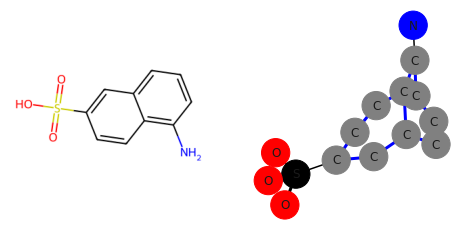

In [ ]:
from modules.MOL.mol_graph import draw_graph
from modules.visualization.define_colors import *
import matplotlib.pyplot as plt

EXAMPLE_ID = 0
example = df.loc[EXAMPLE_ID]
m = example["Metabolite"]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1]}, sharey=False)
set_light_theme()

img = m.draw(ax=axs[0])
draw_graph(m.Graph, ax=axs[1])

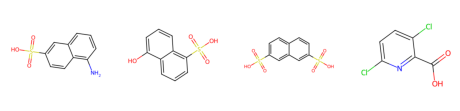

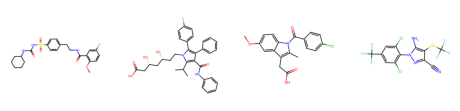

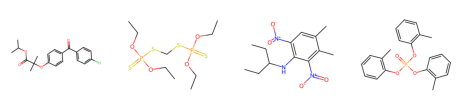

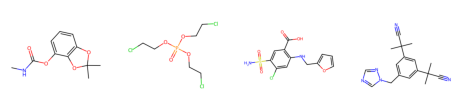

In [ ]:
from modules.MOL.mol_graph import draw_graph
from modules.visualization.define_colors import *
import matplotlib.pyplot as plt


EXAMPLE_ID = 0
example = df.loc[EXAMPLE_ID]
m = example["Metabolite"]

fig, axs = plt.subplots(1, 4, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1,1,1]}, sharey=False)
set_light_theme()

img = m.draw(ax=axs[0])
m2 = df.loc[EXAMPLE_ID + 2]["Metabolite"]
img = m2.draw(ax=axs[1])
img = df.loc[EXAMPLE_ID + 1]["Metabolite"].draw(ax=axs[2])
img = df.loc[EXAMPLE_ID + 3]["Metabolite"].draw(ax=axs[3])
plt.show()


EXAMPLE_ID = 60
example = df.loc[EXAMPLE_ID]
m = example["Metabolite"]

fig, axs = plt.subplots(1, 4, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1,1,1]}, sharey=False)
set_light_theme()

img = m.draw(ax=axs[0])
m2 = df.loc[EXAMPLE_ID + 2]["Metabolite"]
img = m2.draw(ax=axs[1])
img = df.loc[EXAMPLE_ID + 1]["Metabolite"].draw(ax=axs[2])
img = df.loc[EXAMPLE_ID + 3]["Metabolite"].draw(ax=axs[3])
plt.show()

EXAMPLE_ID = 200
example = df.loc[EXAMPLE_ID]
m = example["Metabolite"]

fig, axs = plt.subplots(1, 4, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1,1,1]}, sharey=False)
set_light_theme()

img = m.draw(ax=axs[0])
m2 = df.loc[EXAMPLE_ID + 2]["Metabolite"]
img = m2.draw(ax=axs[1])
img = df.loc[EXAMPLE_ID + 1]["Metabolite"].draw(ax=axs[2])
img = df.loc[EXAMPLE_ID + 3]["Metabolite"].draw(ax=axs[3])
plt.show()

EXAMPLE_ID = 120
example = df.loc[EXAMPLE_ID]
m = example["Metabolite"]

fig, axs = plt.subplots(1, 4, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1,1,1]}, sharey=False)
set_light_theme()

img = m.draw(ax=axs[0])
m2 = df.loc[EXAMPLE_ID + 2]["Metabolite"]
img = m2.draw(ax=axs[1])
img = df.loc[EXAMPLE_ID + 1]["Metabolite"].draw(ax=axs[2])
img = df.loc[EXAMPLE_ID + 3]["Metabolite"].draw(ax=axs[3])
plt.show()

#### Bond Features

{'AROMATIC': 2388, 'DOUBLE': 402, 'SINGLE': 2822, 'TRIPLE': 10}
[2388, 402, 2822, 10]


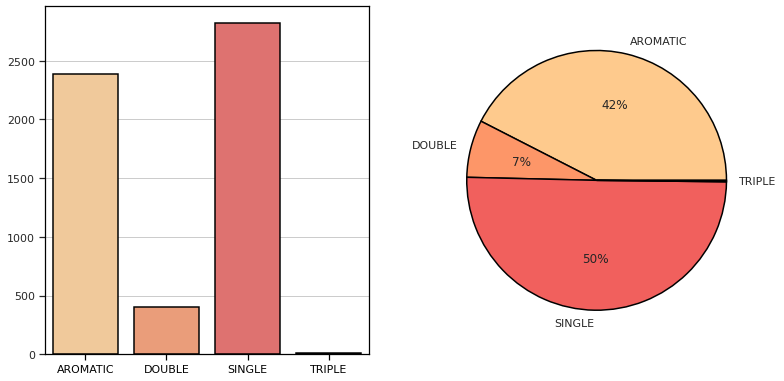

In [ ]:
color_palette = define_figure_style("magma_white")


fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)

edges_bond_types =  [item for items in list(df["Metabolite"].apply(lambda x: getattr(x, "edge_bond_names"))) for item in items]
bond_types = {bond: edges_bond_types.count(bond) for bond in np.unique(edges_bond_types)}
print(bond_types)
print(list(bond_types.values()))

sns.barplot(ax=axs[0], x=list(bond_types.keys()), y=list(bond_types.values()), palette=color_palette, edgecolor="black", linewidth=1.5)
_,labels,autotexts = axs[1].pie(list(bond_types.values()), labels=list(bond_types.keys()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5}, autopct='%1.0f%%')

for i in range(len(labels)):
    if labels[i].get_text() == "TRIPLE":
        autotexts[i].remove()
plt.show()

#### Atom Features

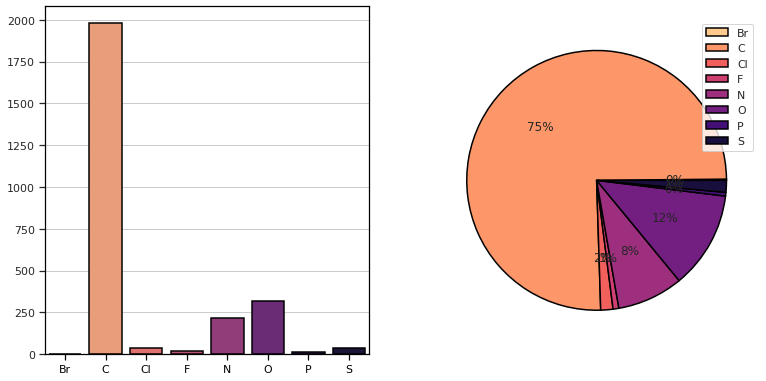

{'Br': 4, 'C': 1981, 'Cl': 40, 'F': 19, 'N': 216, 'O': 318, 'P': 12, 'S': 39}
With 95.7% CNO


In [ ]:
from modules.visualization.define_colors import define_figure_style
color_palette = define_figure_style("magma_white")


elems = [e for mol in list(df["Metabolite"].apply(lambda x: getattr(x, "node_elements")).values) for e in mol]
elem_types = {e: elems.count(e) for e in np.unique(elems)}

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)
sns.barplot(ax=axs[0], x=list(elem_types.keys()), y=list(elem_types.values()), palette=color_palette, edgecolor="black", linewidth=1.5)
_,labels,autotexts = axs[1].pie(list(elem_types.values()), colors=color_palette, wedgeprops={"edgecolor": "black", "linewidth": 1.5}, autopct='%1.0f%%')

axs[1].legend(list(elem_types.keys()))
plt.show()
print(elem_types)
cno = (elem_types["C"]+elem_types["O"]+elem_types["N"])*100 / sum(elem_types.values())
print(f"With {cno:.01f}% CNO")

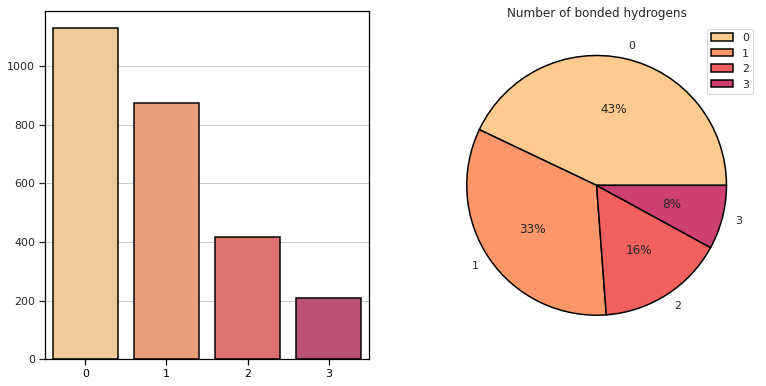

{0: 1129, 1: 874, 2: 417, 3: 209}


In [ ]:
elems = [e for mol in list(df["Metabolite"].apply(lambda x: [a.GetTotalNumHs() for a in getattr(x, "atoms_in_order")]).values) for e in mol]
elem_types = {e: elems.count(e) for e in np.unique(elems)}

fig, axs = plt.subplots(1, 2, figsize=(12.8, 6.4), sharey=False)
sns.barplot(ax=axs[0], x=list(elem_types.keys()), y=list(elem_types.values()), palette=color_palette, edgecolor="black", linewidth=1.5)
_,labels,autotexts = axs[1].pie(list(elem_types.values()), colors=color_palette, labels=list(elem_types.keys()), wedgeprops={"edgecolor": "black", "linewidth": 1.5}, autopct='%1.0f%%')

axs[1].legend(list(elem_types.keys()))
plt.title("Number of bonded hydrogens")
plt.show()
print(elem_types)

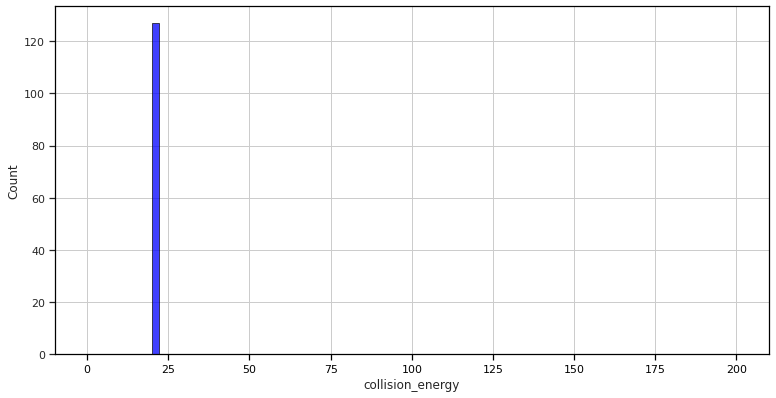

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

d = {"collision_energy": df["Metabolite"].apply(lambda x: x.metadata["collision_energy"])}

sns.histplot(ax=ax, data=d, x='collision_energy', color="blue", fill=True, binwidth=2, edgecolor="black", binrange=[0, 200])#, order=list(range(0,200)))
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['axes.edgecolor'] = 'black'
plt.show()

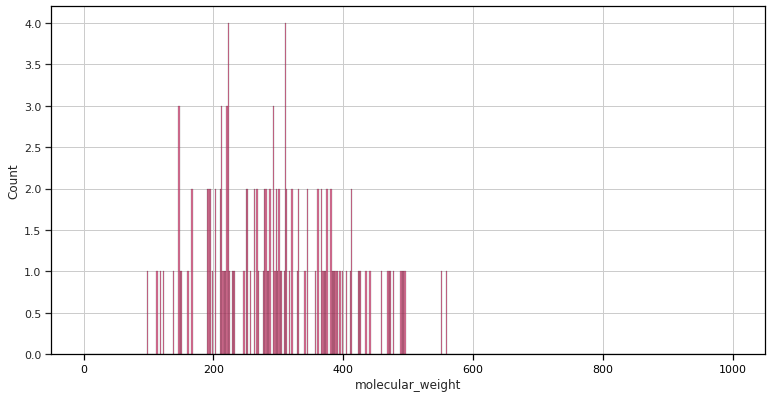

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12.8, 6.4))

d = {"molecular_weight": df["Metabolite"].apply(lambda x: x.metadata["molecular_weight"])}

sns.histplot(ax=ax, data=d, x='molecular_weight', color=color_palette[3], fill=True, binwidth=2, edgecolor="black", binrange=[0, 1000])#, order=list(range(0,200)))
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['axes.edgecolor'] = 'black'
plt.show()

#### Peak annotations


In [ ]:
%%capture
from modules.MOL.constants import PPM
df["Metabolite"].apply(lambda x: x.fragment_MOL(depth=1))
df.apply(lambda x: x["Metabolite"].match_fragments_to_peaks(x["peaks"]["mz"], x["peaks"]["intensity"], tolerance=100 *PPM), axis=1)

In [ ]:
d100 = pd.DataFrame({"num_peak_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_matches"]),
     "num_non_precursor_matches": df["Metabolite"].apply(lambda x: x.match_stats["num_non_precursor_matches"]),
     "num_peak_match_conflicts": df["Metabolite"].apply(lambda x: x.match_stats["num_peak_match_conflicts"]),
     "group": "100 PPM"})


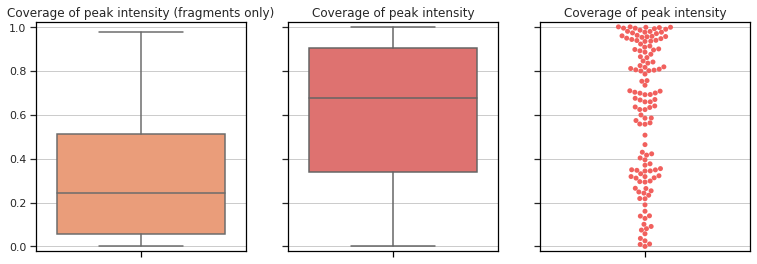

Filtering would drop 20 out of 127


In [ ]:
# TODO Implement conflict solver

coverage_tracker = {"counts": [], "all": [], "coverage": [], "fragment_only_coverage": []}

drop_index = []
for i,d in df.iterrows():
    M = d["Metabolite"]
    
    
    coverage_tracker["counts"] += [M.match_stats["counts"]]
    coverage_tracker["all"] += [M.match_stats["ms_all_counts"]]
    coverage_tracker["fragment_only_coverage"] += [M.match_stats["coverage_wo_prec"]]
    coverage_tracker["coverage"] += [M.match_stats["coverage"]]
    
    #if M.edge_break_prob_wo_precursor.sum() <= 0.01:
    #    drop_index.append(i)
    #if M.edge_break_prob.sum() < 0.05: # TODO
    #    drop_index.append(i)
    
    if M.match_stats["coverage"] < 0.25: # Filter if total coverage is too low
        drop_index.append(i)
    #if M.match_stats["coverage_wo_prec"] < 0.1: # Filter if fragment coverage is too low (intensity wise)
    #    drop_index.append(i)
    
# filter low res instruments TODO update to low quality spectra
is_iontrap = df["Metabolite"].apply(lambda x: x.metadata["instrument"] == "IT/ion trap")
drop_index += list(df[is_iontrap].index)

fig, axs = plt.subplots(1, 3, figsize=(12.8, 4.2), sharey=True)

plt.ylim([-.02,1.02])
sns.boxplot(ax=axs[0], data=coverage_tracker, y="fragment_only_coverage", color=color_palette[1])
sns.boxplot(ax=axs[1], data=coverage_tracker, y="coverage", color=color_palette[2])
sns.swarmplot(ax=axs[2], data=coverage_tracker, y="coverage", color=color_palette[2])
axs[0].set_title("Coverage of peak intensity (fragments only)")
axs[1].set_title("Coverage of peak intensity")
axs[2].set_title("Coverage of peak intensity")
plt.show()

print(f"Filtering would drop {len(drop_index)} out of {df.shape[0]}")


Load CFM-ID TEST

In [ ]:
import modules.IO.cfmReader as cfmReader
# time CFM-ID 4: -> 12m16,571s

cf = cfmReader.read(f"{home}/data/metabolites/cfm-id/casmi16_positive_predictions.txt", as_df=True)
cf.head(2)

,#ID,#SMILES,#InChiKey,#Formula,#PMass,peaks10,peaks20,peaks40,14 110.0461215481 N#CN,18 127.0726706441 NC1,...,221 454.3527000561 C#CC,224 451.3781865321 C#CC,232 466.3890855641 C#CC,237 450.3941709441 C#CC,239 468.4047356281 C#CC,240 468.4047356281 C#CC,243 478.3890855641 C#CC#CC,244 478.3890855641 C#CC#CC,249 350.2689704321 C#CC#CC,266 468.4047356281 C#CC
0,ID=Challenge-082,SMILES=NC1=NC(NC2CC2)=NC(N)=N1,InChiKey=LVQDKIWDGQRHTE-UHFFFAOYSA-N,Formula=C6H10N6,PMass=167.10397,"{'mz': [127.07267, 167.10397], 'intensity': [1...","{'mz': [127.07267, 167.10397], 'intensity': [4...","{'mz': [43.02907, 68.02432, 110.04612], 'inten...",4 110.0461215481 N#CN=C=NC(N)=[NH2+],8 127.0726706441 NC1=NC(=[NH2+])NC(N)=N1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID=Challenge-083,SMILES=CN(C)C1=CC=NC=C1,InChiKey=VHYFNPMBLIVWCW-UHFFFAOYSA-N,Formula=C7H10N2,PMass=123.09167,"{'mz': [121.07602, 123.09167], 'intensity': [2...","{'mz': [70.06513, 94.06513, 96.08078, 106.0651...","{'mz': [51.02293, 66.03383, 68.04948, 70.06513...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


CASMI TRAINING DATA